# <h1><center> <font color='red'> Two-Stage-To-Orbit design problem</font> </h1></center>

<center> L. BREVAULT (ONERA/DTIS), M. BALESDENT (ONERA/DTIS), G. SIRE (ONERA/DTIS)</center>
<center> loic.brevault@onera.fr, mathieu.balesdent@onera.fr, glen.sire@onera.fr </center>
<center> Nov 2021  </center>

## <font color='blue'> Problem description:</font>

- <font color='blue'> Simulation</font> of a **Two-Stage-To-Orbit expendable launch vehicle** using four coupled disciplines:
    - Propulsion,
    - Aerodynamics,
    - Structure and sizing,
    - Trajectory.
- <font color='blue'> Mission</font>: injection of a **5t** payload into a **700km x 700km** circular orbit (equatorial)
- <font color='blue'> Trajectory simulation </font> in the local geographic frame, 3D, non-rotating Earth:
<center>
$\dot{r} = V \sin(\gamma)$
</center> 
<center>
$\dot{V} = -\frac{1}{2m} \rho S_{ref} C_X V^2 -g(r) \sin(\gamma) + \frac{T}{m} \cos(\theta-\gamma) +\omega_E^2 r \sin(\gamma)$ 
</center>
<center>   
$\dot{\gamma} = \left(\frac{V}{r} - \frac{g(r)}{V}\right) \cos(\gamma) + \frac{T}{mV} \sin(\theta - \gamma)+ 2\omega_E + \frac{\omega_E^2 r \cos(\gamma)}{V} + \frac{L}{mV}$
</center>    
<center>
$\dot{l} = \frac{V}{r} \cos(\gamma) $
</center> 
<center>       
$\dot{m} = - q $
</center>    
where:
$r$: altitude (m),
$V$: norm of velocity (m/s),
$\gamma$: flight path angle (rad),
$l$: longitude (rad),
$m$: mass (kg),
$\theta$: pitch angle (rad),
$S_{ref}$: surface of reference ($m^2$),
$T$: thrust (N),
$\rho$: air density ($kg/m^3$),
$C_X$: drag coefficient,
$g(r)$: Earth gravity ($m/s^2$),
$q$: mass flow rate ($kg/m^3$) and $\alpha$: angle of attack (rad).

<img src="angles_definition.png" alt="Drawing" style="width: 300px;"/>

- <font color='blue'> Trajectory phases and control </font>:
    - Lift-off: $\theta = \pi/2$
    - Pitch-over maneuver: $\theta(t) = \gamma - \frac{\Delta_{\theta} * t}{\Delta_t}$
        - where $\Delta_{\theta}$ is the variation (in rad) of $\theta$ during the maneuver and $\Delta_t$ is the duration of the maneuver (in s)
    - Gravity turn: return to angle of attack of zero and then $\theta = \gamma$ ($\alpha = 0.$)
    - Exo-atmospheric command for first stage: $\theta$ is optimized by a linear interpolation control law (parameters are waypoints of $\theta$ as a function of time, 2 parameters are used: $\theta$ at the time at which the exo-atmospheric phase begins and $\theta$ at the end of the first stage flight)
    - Separation between the first and second stages
    - Second stage flight (bi-linear tangent command): $\tan(\theta) = \frac{a^\xi \tan(\theta_i)+(\tan(\theta_f)-a^\xi \tan(\theta_i))t}{a^\xi+(1-a^\xi)t}$
        - where $a$ is a constant, $\xi$ a parameter defining the shape of the bi-linear tangeant law, $\theta_i$ and $\theta_f$ the pitch angles at the beginning and at the end of the phase, see [F. Castellini PhD thesis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&cad=rja&uact=8&ved=2ahUKEwiYq9yN9urhAhWaAmMBHeMHDmQQFjABegQIARAC&url=https%3A%2F%2Fwww.politesi.polimi.it%2Fbitstream%2F10589%2F56841%2F1%2F201203_PhD_Castellini.pdf&usg=AOvVaw14PiJUsq8IUSFMbhVEfBef) page 69
    - Coast phase (balistic flight to reach the final orbit -- not simulated)
    - Orbit circularization boost (-- not simulated)

<img src="trajectory_phase.png" alt="Drawing" style="width: 600px;"/>


- <font color='blue'> Propulsion</font>: simplified model based on [M. Balesdent PhD thesis](https://tel.archives-ouvertes.fr/tel-00659362/document) pages 100-101
- <font color='blue'> Structure and sizing</font>: Mass Estimating Relations (MER) based on [F. Castellini PhD thesis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&cad=rja&uact=8&ved=2ahUKEwiYq9yN9urhAhWaAmMBHeMHDmQQFjABegQIARAC&url=https%3A%2F%2Fwww.politesi.polimi.it%2Fbitstream%2F10589%2F56841%2F1%2F201203_PhD_Castellini.pdf&usg=AOvVaw14PiJUsq8IUSFMbhVEfBef) pages 79-85
- <font color='blue'> Aerodynamics </font>: fixed drag table $C_X(\text{Mach},\alpha)$ as a function of Mach and angle of attack $\alpha$ (rad) obtained for a representative TSTO launcher geometry using low fidelity aerodynamics code (e.g. MissileDATCOM).


- Use of [OpenMDAO](http://openmdao.org/) to connect the different disciplines as a group


## <font color='blue'> Problem simulation:</font>

Import of general python librairy 

In [1]:
import numpy as np
import pandas as pd
import sys
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import pyplot as plt

Import OpenMDAO + CMA-ES optimization algorithm

-Required packages : 
    - pip install openmdao
    - pip install cma
    - pip install geopy
    - pip install pandas

In [2]:
import openmdao.api as om
import cma

Import of specific Python functions for launch vehicle design

In [3]:
import Launch_vehicle_Group
import post_traitement
import result_vizualization
import constants as Cst
import specifications as Spec

Creation of an OpenMDAO problem using the launch vehicle group

In [4]:
P_obj = om.Problem()
P_obj.model=Launch_vehicle_Group.Launcher_vehicle()
P_obj.setup()

Visualize the N2 chart to visualize the connections between the disciplines

In [7]:
om.n2(P_obj,outfile='n2.html',show_browser=True)

### Fixed Point Iteration (FPI)

Enable the solving of interdisciplinary couplings between the 'trajectory' and the 'sizing and structure (struct_1)' disciplines. The feedback coupling "Pdyn_max_dim" is an input of the 'sizing and structure' discipline and "max_pdyn_load_ascent_stage_1" is an output of the trajectory discipline and these variables have to be equal to satisfy the interdisciplinary couplings. 

The variable "Pdyn_max_dim" is initialized to run the propulsion, the aerodynamics, the structure and then the trajectory disciplines and the output of the trajectory "max_pdyn_load_ascent_stage_1" is compared to the input of the structure "Pdyn_max_dim". If the difference is too large, the input of the structure "Pdyn_max_dim" is updated with the corresponding output of the trajectory discipline and a new evaluation of the disciplines is carried out.

For the stage fallout: use variable 'is_fallout': if is_fallout=0: no simulation of stage 1 fallout else if is_fallout=1: simulation of stage 1 fallout (not running for the moment, see Project 2)

In [8]:
def FPI(tuple_input):
#    x = tuple_input[0]
#    lowerbnd_exp = tuple_input[1]
#    upperbnd_exp = tuple_input[2]
    Pb = tuple_input
#    
    Pb.setup(check = False)
#    XX = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp)*x
    Pb['Diameter_stage_1'] = 5.0
    Pb['Diameter_stage_2'] = 5.0
    Pb['Mass_flow_rate_stage_1'] = 250.
    Pb['Mass_flow_rate_stage_2'] = 250.
    Pb['Thrust_stage_1'] = 1000.
    Pb['Thrust_stage_2'] = 800.
    Pb['OF_stage_1'] = 5.0
    Pb['OF_stage_2'] = 5.0
    Pb['Pc_stage_1'] = 100.0
    Pb['Pc_stage_2'] = 100.0
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 8.
    Pb['N_eng_stage_2'] = 1.
    Pb['Prop_mass_stage_1'] = 320000.
    Pb['Prop_mass_stage_2'] = 75000.
    Pb['thetacmd_i'] = 2.72
    Pb['thetacmd_f'] = 10.
    Pb['ksi'] = 0.293
    Pb['Pitch_over_duration'] = 5.
    Pb['Exit_nozzle_area_stage_1'] = 0.79
    Pb['Exit_nozzle_area_stage_2'] = 3.6305
    Pb['Delta_vertical_phase'] = 10.
    Pb['Delta_theta_pitch_over'] = 1.        
    Pb['command_stage_1_exo'] = np.array([30.,-20.])
    Pb['is_fallout']=0. #0: no simulation of stage 1 fallout, 1: simulation of stage 1 fallout

    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k=0
    while error>1. and k<20:
        Pb.run_model()
        error = abs(Pb['Pdyn_max_dim']-Pb['max_pdyn_load_ascent_stage_1']/1e3)
        Pb['Pdyn_max_dim'] = Pb['max_pdyn_load_ascent_stage_1']/1e3
        k = k+1
        print('Fixed Point Iteration: ',k ,', error: ', np.round(error[0],2), ', Input pdyn max (kPa): ', np.round(Pb['Pdyn_max_dim'][0],2))
    return Pb

In [9]:
P_out = FPI(P_obj)
GLOW, contraintes = post_traitement.post_traitement(P_out)

Fixed Point Iteration:  1 , error:  3.83 , Input pdyn max (kPa):  36.17
Fixed Point Iteration:  2 , error:  0.01 , Input pdyn max (kPa):  36.18


## Plot outputs of trajectory simulation

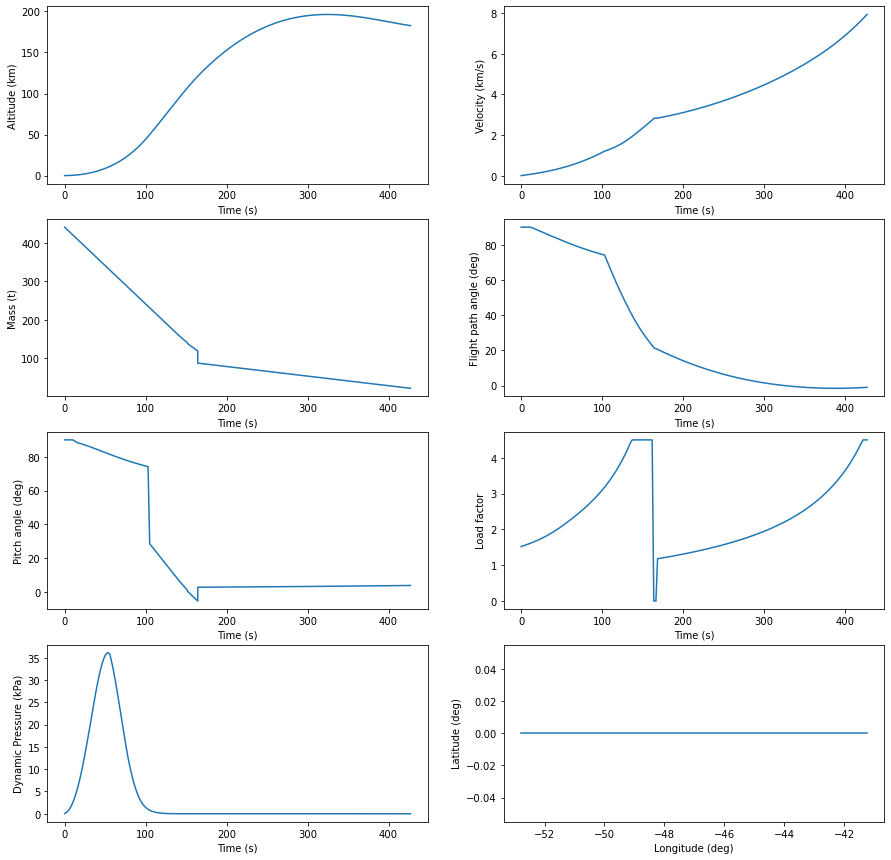

In [10]:
result_vizualization.plots_output(P_out)

### Output data from simulation

In [11]:
data = [[P_out['GLOW'][0]/1e3,
         P_out['Dry_mass_stage_1'][0]/1e3,
         P_out['Dry_mass_stage_2'][0]/1e3,
        P_out['Prop_mass_stage_1'][0]/1e3,
        P_out['Prop_mass_stage_2'][0]/1e3]]
df = pd.DataFrame(data, columns=["GLOW (t)", "Dry_mass_stage_1  (t)", 
                                     "Dry_mass_stage_2  (t)", "Prop_mass_stage_1 (t)", 
                                     "Prop_mass_stage_2 (t)"])
df.round(3)

,GLOW (t),Dry_mass_stage_1 (t),Dry_mass_stage_2 (t),Prop_mass_stage_1 (t),Prop_mass_stage_2 (t)
0,441.198,32.27,6.928,320.0,75.0


## <font color='blue'> Optimization problem:</font>

\begin{eqnarray}
\text{min} & & \text{GLOW}(\mathbf{z}) \\
\text{w.r.t} & & \mathbf{z}=[\text{M}_{prop1},\text{M}_{prop2},\theta_i, \theta_f, \xi, \Delta_t, \Delta_\theta, t_{vertical}, \theta_{cmd} ] \\
\text{s.t.} & & \alpha_{ascent}(\mathbf{z}) \leq 15 \\
 & & NX_{ascent}(\mathbf{z}) \leq 4.5 \\
 & & Pdyn_{ascent}(\mathbf{z}) \leq 40. \\
 & & HeatFlux_{ascent}(\mathbf{z}) \leq 100. \\
 & & \text{Apogee}(\mathbf{z}) = 700. \\
 & & \text{Perigee}_{CoastPhase}(\mathbf{z}) \geq 140. \\
 & & M_{Circularization}(\mathbf{z}) \geq 0. \\
 &&\mathbf{z}_\text{min} \leq \mathbf{z} \leq \mathbf{z}_\text{max}
\end{eqnarray}

with:
- GLOW: Gross-Lift-Off Weight
- $\mathbf{z} \in \mathbb{R}^{10}$, in practice the input variables are normalized into $[0. ,1.]^{10}$
- $\text{M}_{prop1}$: Prop_mass_stage_1
- $\text{M}_{prop2}$: Prop_mass_stage_2
- $\theta_i$: thetacmd_i, pitch angle begining of bilinear phase 
- $\theta_f$: thetacmd_f, pitch angle end of bilinear phase 
- $\xi$: ksi, shape parameter of bilinear phase 
- $\Delta_t$: Pitch_over_duration
- $\Delta_\theta$: Delta_theta_pitch_over
- $t_{vertical}$: Delta_vertical_phase
- $\theta_{cmd}$: command_stage_1_exo (vector of dimension 2)

The constraints are defined in the specification.py file:
- $\alpha_{ascent}$: angle of attack during the ascent phase that must be below 15 degrees
- $NX_{ascent}$: axial load factor during the ascent phase that must be below 4.5g
- $Pdyn_{ascent}$: dynamic pressure during the ascent phase that must be below 40kPa
- $HeatFlux_{ascent}$: heat flux during the ascent phase that must be below 100 $W/m^2$
- $\text{Apogee}$: Apogee altitude of the coast phase transition orbit must be equal to 700km
- $\text{Perigee}_{CoastPhase}$: Perigee altitude of the coast phase transition orbit must be above 140km
- $M_{Circularization}$: remaining propellant mass before the circularization burn must be sufficient to circularize the final orbit 700 x 700km 

### FPI for optimization

In [12]:
def FPI_optim(x,lowerbnd_exp,upperbnd_exp,Pb):

    Pb.setup(check = False)
    XX = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp)*x
    Pb['Diameter_stage_1'] = 5.0
    Pb['Diameter_stage_2'] = 5.0
    Pb['Mass_flow_rate_stage_1'] = 300.
    Pb['Mass_flow_rate_stage_2'] = 200.
    Pb['Thrust_stage_1'] = 1000.
    Pb['Thrust_stage_2'] = 1000. # not used
    Pb['OF_stage_1'] = 5.
    Pb['OF_stage_2'] = 5.5
    Pb['Pc_stage_1'] = 80.0
    Pb['Pc_stage_2'] = 60.0
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 6.
    Pb['N_eng_stage_2'] = 1.
    Pb['Prop_mass_stage_1'] = XX[0]*1e3
    Pb['Prop_mass_stage_2'] = XX[1]*1e3
    Pb['thetacmd_i'] = XX[2]
    Pb['thetacmd_f'] = XX[3] 
    Pb['ksi'] = XX[4]
    Pb['Pitch_over_duration'] = XX[5]
    Pb['Exit_nozzle_area_stage_1'] = 0.79
    Pb['Exit_nozzle_area_stage_2'] = 3.6305
    Pb['Delta_vertical_phase'] = XX[6]
    Pb['Delta_theta_pitch_over'] = XX[7]        
    Pb['command_stage_1_exo'] = XX[8:10]
    Pb['is_fallout']=0. #0: no simulation of stage 1 fallout, 1: simulation of stage 1 fallout

    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k=0
    while error>1. and k<20: # Solving of Fixed Point Iteration via Gauss-Seidel
        Pb.run_model()
        error = abs(Pb['Pdyn_max_dim']-Pb['max_pdyn_load_ascent_stage_1']/1e3)
        Pb['Pdyn_max_dim'] = Pb['max_pdyn_load_ascent_stage_1']/1e3
        k = k+1
    return Pb

### Definition of objective function
Definition the objective function for evolutionary algorithm Covariance Matrix Adaptation (CMA-ES) more details on CMA-ES [here](http://cma.gforge.inria.fr/) and [here](https://en.wikipedia.org/wiki/CMA-ES). Penalization strategy is used to handle the different constraints in this example.
If the constraints are not satisfied, the "penalized objective function" corresponds to the minimization of the constraint violation, and if the constraints are satisfied, $-(1e6 - GLOW)/1e5$ is minimized: 
when the constraints are not satisfied, the objective function takes as value the sum of non satisfied constraints.

In [13]:
def Objective_function(x,lowerbnd_exp,upperbnd_exp,Pb,simu):
    P_out = FPI_optim(x,lowerbnd_exp,upperbnd_exp,Pb)
    GLOW, contraintes = post_traitement.post_traitement(P_out)
    if simu==0: 
        if len(np.where(contraintes>1e-2)[0])==0:            
            return -(1e6 - GLOW)/1e5
        else:

            cont = np.sum(contraintes[np.where(contraintes>0)[0]])
            return cont
    else :
        if len(np.where(contraintes>1e-2)[0])==0:
            return GLOW/1e5,-5 
        else:
            return GLOW/1e5,contraintes    

### Definition of lower and upper bounds for the normalization during optimization

In [14]:
lowerbnd_exp = np.array([150.,#Prop_mass_stage_1
                         20., #Prop_mass_stage_2
                          0.,#theta_cmd_i
                         -10.,#theta_cmd_f
                         -1.,#ksi
                         5., #Pitch_over_duration
                         5., #Delta_vertical_phase
                         1., #Delta_theta_pitch_over
                         10.,10.]) #command_stage_1_exo

upperbnd_exp = np.array([600.,#Prop_mass_stage_1
                         200., #Prop_mass_stage_2
                         50.,#theta_cmd_i
                         20.,#theta_cmd_f
                         1.,#ksi
                         20., #Pitch_over_duration
                         20., #Delta_vertical_phase
                         10., #Delta_theta_pitch_over
                         70.,70.]) #command_stage_1_exo

### Definition of CMA-ES options and bounds

In [15]:
lower = np.zeros([1,len(lowerbnd_exp)])
upper = np.ones([1,len(upperbnd_exp)])  
options = cma.CMAOptions()
bound_cma = np.array([lower[0],upper[0]])
options = {'ftarget':-9e7,'tolfun':1e-5,'tolx':1e-6,'seed':2,
           'bounds':[bound_cma[0],bound_cma[1]],'popsize':12,'maxiter':100,'verb_disp': 1}
simu = 0
init = np.ones(len(lowerbnd_exp))*0.5
critere_cma = lambda x: Objective_function(x,lowerbnd_exp,upperbnd_exp,P_obj,simu)

Parameters of CMA are regrouped into a dictionnary "options", of which the keys are the following: 
- ftarget: stopping value of objective function,
- tolfun: tolerance value on objective functon,
- tolx: tolerance value on design variable variations,
- seed: seed of random generator of CMA-ES
- bounds: (normalized) bounds on the design variables,
- popsize: population size of CMA
- maxiter: maximum number of iterations,
- verdisp: display option

### Running of CMA-ES
Parameter $\sigma$ is set at 0.2 in the following example, see CMA documentation

In [16]:
res = cma.fmin(critere_cma,init,.2,options)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 10 (seed=2, Mon Nov 15 16:27:30 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 7.009361667898098e+03 1.0e+00 1.89e-01  2e-01  2e-01 0:02.3
    2     24 2.626912895821953e+01 1.2e+00 1.83e-01  2e-01  2e-01 0:04.5
    3     36 3.774428581593899e+01 1.3e+00 1.72e-01  2e-01  2e-01 0:06.2
    4     48 2.187920646314429e+01 1.3e+00 1.72e-01  2e-01  2e-01 0:10.5
    5     60 3.522218637582093e+00 1.4e+00 1.66e-01  2e-01  2e-01 0:12.8
    6     72 -5.882444538691285e+00 1.4e+00 1.50e-01  1e-01  2e-01 0:15.5
    7     84 1.467139639505596e+01 1.4e+00 1.42e-01  1e-01  1e-01 0:18.4
    8     96 7.271240440154187e+00 1.4e+00 1.58e-01  1e-01  2e-01 0:21.0
    9    108 9.664573976404686e-01 1.5e+00 1.55e-01  1e-01  2e-01 0:24.4
   10    120 2.783258868994599e+00 1.6e+00 1.45e-01  1e-01  2e-01 0:26.9
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    132 3.282417792624794e-01 1.7

### Results of optimization
#### Optimal value of the design variables, of the objective function and penalized constraints and of the GLOW
Be careful that the optimal value of the design variables do not reach the bounds defined in lowerbnd_exp and upperbnd_exp especially for the propellant masses. If it is the case, modify the bounds and rerun the optimization.

In [17]:
print('>> Optimal design variable values',res[0])
print('>> Objective, Penalized Constraint',Objective_function(res[0],lowerbnd_exp,upperbnd_exp,P_obj,1))
print('>> Optimal GLOW (t)', P_obj['GLOW']/1e3)

>> Optimal design variable values [0.23527546 0.36153667 0.39784285 0.53903249 0.22424615 0.96230176
 0.75167229 0.8693451  0.44461484 0.17382506]
>> Objective, Penalized Constraint (3.8145964187216097, -5)
>> Optimal GLOW (t) [381.45964187]


### Plots of the results of optimization

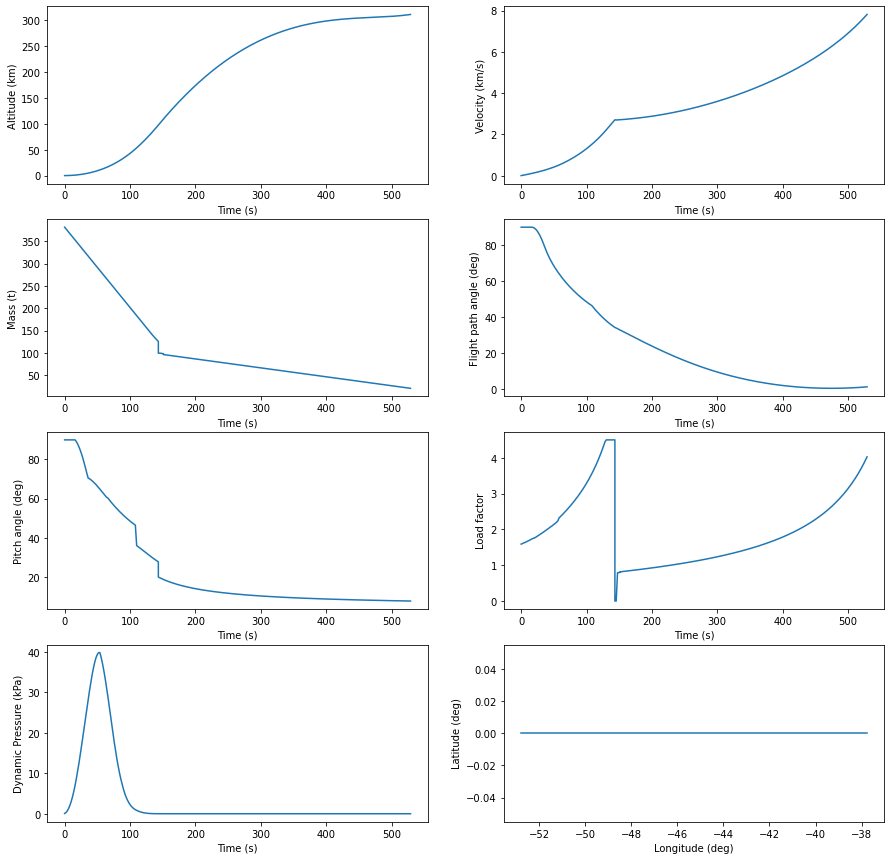

In [18]:
P_out = FPI_optim(res[0],lowerbnd_exp,upperbnd_exp,P_obj)
result_vizualization.plots_output(P_out)

In [19]:
data = [[P_out['GLOW'][0]/1e3,
         P_out['Dry_mass_stage_1'][0]/1e3,
         P_out['Dry_mass_stage_2'][0]/1e3,
        P_out['Prop_mass_stage_1'][0]/1e3,
        P_out['Prop_mass_stage_2'][0]/1e3]]
df = pd.DataFrame(data, columns=["GLOW (t)", "Dry_mass_stage_1  (t)", 
                                     "Dry_mass_stage_2  (t)", "Prop_mass_stage_1 (t)", 
                                     "Prop_mass_stage_2 (t)"])
df.round(3)

,GLOW (t),Dry_mass_stage_1 (t),Dry_mass_stage_2 (t),Prop_mass_stage_1 (t),Prop_mass_stage_2 (t)
0,381.46,26.13,7.379,255.874,85.077
